In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo

In [2]:
import scipy.linalg
from scipy.special import legendre

class LDN(nengo.Process):
    def __init__(self, theta, q, size_in=1):
        self.q = q              # number of internal state dimensions per input
        self.theta = theta      # size of time window (in seconds)
        self.size_in = size_in  # number of inputs

        # Do Aaron's math to generate the matrices A and B so that
        #  dx/dt = Ax + Bu will convert u into a legendre representation over a window theta
        #  https://github.com/arvoelke/nengolib/blob/master/nengolib/synapses/analog.py#L536
        A = np.zeros((q, q))
        B = np.zeros((q, 1))
        for i in range(q):
            B[i] = (-1.)**i * (2*i+1)
            for j in range(q):
                A[i,j] = (2*i+1)*(-1 if i<j else (-1.)**(i-j+1))
        self.A = A / theta
        self.B = B / theta

        super().__init__(default_size_in=size_in, default_size_out=q*size_in)

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        state = np.zeros((self.q, self.size_in))

        # Handle the fact that we're discretizing the time step
        #  https://en.wikipedia.org/wiki/Discretization#Discretization_of_linear_state_space_models
        Ad = scipy.linalg.expm(self.A*dt)
        Bd = np.dot(np.dot(np.linalg.inv(self.A), (Ad-np.eye(self.q))), self.B)

        # this code will be called every timestep
        def step_legendre(t, x, state=state):
            state[:] = np.dot(Ad, state) + np.dot(Bd, x[None, :])
            return state.T.flatten()
        return step_legendre

    def get_weights_for_delays(self, r):
        # compute the weights needed to extract the value at time r
        # from the network (r=0 is right now, r=1 is theta seconds ago)
        r = np.asarray(r)
        m = np.asarray([legendre(i)(2*r - 1) for i in range(self.q)])
        return m.reshape(self.q, -1).T



Let's run it with the normal nengo approach

In [3]:
freq = 5
theta = 0.1
q = 10

model = nengo.Network()
with model:
    stim = nengo.Node(lambda t: [np.sin(t*freq*2*np.pi), np.cos(t*freq*2*np.pi)])
    
    ldn = nengo.Node(LDN(theta=theta, q=q, size_in=2))
    
    output = nengo.Node(None, size_in=2)
    nengo.Connection(stim, ldn, synapse=None)
    nengo.Connection(ldn[:q], output[0], synapse=None, transform=ldn.output.get_weights_for_delays([1]))
    nengo.Connection(ldn[q:], output[1], synapse=None, transform=ldn.output.get_weights_for_delays([1]))
    p_output = nengo.Probe(output)
    p_stim = nengo.Probe(stim)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(1.0)
    

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

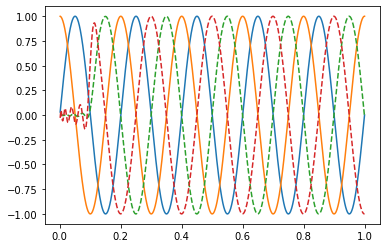

In [4]:
plt.plot(sim.trange(), sim.data[p_stim])
plt.plot(sim.trange(), sim.data[p_output], ls='--')



Let's run it with the cool features of a nengo Process that let you just use it as a component in other systems

In [34]:
t = np.arange(1000)*0.001
x = np.vstack([np.sin(t*freq*2*np.pi), np.cos(t*freq*2*np.pi)]).T

ldn = LDN(theta=theta, q=q, size_in=2)

lg = ldn.apply(x)    # apply the Process to the given input

dec = ldn.get_weights_for_delays(1)

x_dec = np.hstack([lg[:,:q].dot(dec.T), lg[:,q:].dot(dec.T)])



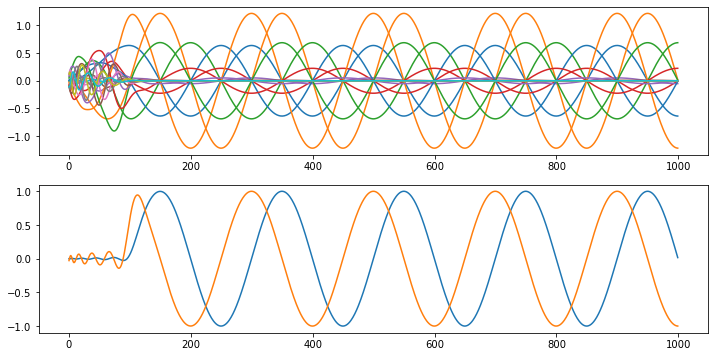

In [35]:
plt.figure(figsize=(12,6))
plt.subplot(2, 1, 1)
plt.plot(lg)
plt.subplot(2, 1, 2)
plt.plot(x_dec)
plt.show()

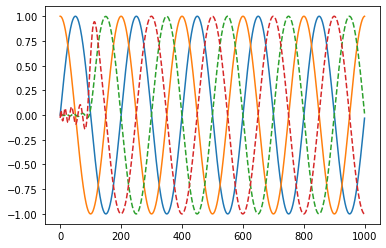

In [38]:
# this should be identical to the above plot using the nengo approach
plt.plot(x)
plt.plot(x_dec, ls='--')

